# First, import required dataset and libraries

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import joblib

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier


from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline

In [20]:
fraudetection = pd.read_csv("../research/creditcard.csv")
fraudetection.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

# Exploratory data analysis

In [21]:
fraudetection.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
228956,145734.0,1.950962,-0.511622,-3.151145,-0.625736,2.638800,3.150498,-0.062783,0.639276,0.227068,...,0.000950,-0.050164,0.060596,0.764574,0.190001,0.574909,-0.090129,-0.072251,69.52,0
189047,128243.0,2.054075,-0.118476,-1.439956,0.185714,0.098373,-0.883433,0.088872,-0.189487,0.491128,...,0.265388,0.858346,-0.041077,-0.322545,0.251491,-0.105298,-0.029421,-0.074031,1.00,0
51976,45220.0,-1.452936,0.969332,-0.050559,-0.873773,2.289858,3.655171,0.099997,1.284458,-0.608033,...,-0.160291,-0.765612,-0.204047,0.970825,0.708231,-0.580811,-0.312182,-0.016122,46.53,0
29817,35642.0,-1.063502,-0.290389,1.573125,3.016919,1.948737,0.294115,-0.104836,0.123160,-3.467082,...,-0.090719,-0.009794,0.169772,-0.342043,-0.412755,0.139412,-0.043165,-0.062709,18.97,0
119710,75555.0,-1.279708,0.425340,1.808749,-0.582334,0.726131,-0.405217,0.565566,-0.034347,-0.248459,...,-0.259153,-0.582846,-0.045263,-0.015032,0.223088,0.000143,-0.229862,-0.155272,7.16,0


In [4]:
fraudetection.shape

(284807, 31)

This function shows whether the imbalance in the dataset

In [22]:
def table(x):
    table1 = 0
    table0 = 0
    for i in range(0, len(x)):
        if x[i] == 1:
            table1 += 1
        else:
            table0 += 1
    if table1 < len(x)*0.10 or table0 < len(x)*0.10:
        status = " There are imbalanced."
    else:
        status = " There not are imbalanced."
    return print("There are " + str(table1) + 
                 " values equal to 1, and " + 
                 str(table0) + " equal to 0." + 
                 status)
table(fraudetection['Class'])

There are 492 values equal to 1, and 284315 equal to 0. There are imbalanced.


Scatter plot to very the distribution of fraud cases

In [23]:
def prep_data(df: pd.DataFrame) -> (np.ndarray, np.ndarray):
    X = df.iloc[:, 2:30]. values
    y = df.Class.values
    return X, y

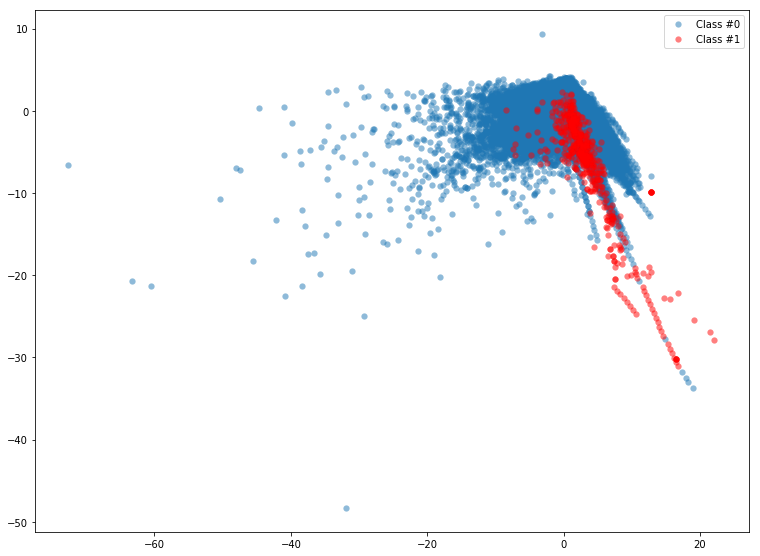

In [24]:
def plot_data(X, y):
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()
    return plt.show()
plt.figure(figsize = [12.8, 9.6])
X, y = prep_data(fraudetection)
plot_data(X, y)

In [25]:
def compare_plot(X, y, X_resemp, y_resemp, method: str):
    plt.subplot(1, 2, 1)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title('Original set')
    plt.subplot(1, 2, 2)
    plt.scatter(X_resemp[y_resemp == 0, 0], X_resemp[y_resemp == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X_resemp[y_resemp == 1, 0], X_resemp[y_resemp == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.title(method)
    plt.show()

making a histogram with the distribution of class.

In [26]:
fraudetection.groupby("Class")["Class"].count()

Class
0    284315
1       492
Name: Class, dtype: int64

Text(0,0.5,'frequency')

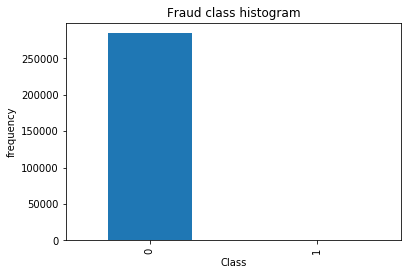

In [27]:
count = pd.value_counts(fraudetection["Class"], sort = True).sort_index()
count.plot(kind='bar')
plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("frequency")

An problem that may arise, is that the model learns one behavior very well, and ignores the other.

Some alternatives are:
- ~Collect more data~;
- ~Changing the performance metric~;
- **And, resampling the dataset.**



# The next step

Resampling the dataset, and data handling.

In [11]:
# # Created sampling function for return the sample size.
# def sampling_func(x, e):
#     n0 = 1 / (e**2)
#     return int((len(x)*n0)/(len(x)+n0))

# sampling_func(fraudetection, e=0.01)

In [12]:
# fraudetection_sample = fraudetection.sample(n=9660)
# table(np.array(fraudetection_sample['Class']))

In [13]:
# X_sample = fraudetection_sample.drop('Class', axis=1).values
# y_sample = fraudetection_sample['Class'].values

First, normalize the amount.

In [28]:
fraudetection['n_mount'] = StandardScaler().fit_transform(np.array(fraudetection['Amount']).reshape(-1, 1))
fraudetection = fraudetection.drop(['Time', 'Amount'], axis=1)
fraudetection.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,n_mount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


### Then, resampling the dataset.

Split the dataset in label, which is the "Class", and the features.

In [29]:
X = fraudetection.drop("Class", axis=1).values
y = fraudetection["Class"].values

Now, create resampling.

### Create split in train and test sets.

In [30]:
# first with the original dataset
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size = 0.3,
                                                   random_state = 42)

# print the length
print("X_train has: " + str(len(X_train)) + " and X_test has: " + str(len(y_test)))

X_train has: 199364 and X_test has: 85443


1. Using random over sample.

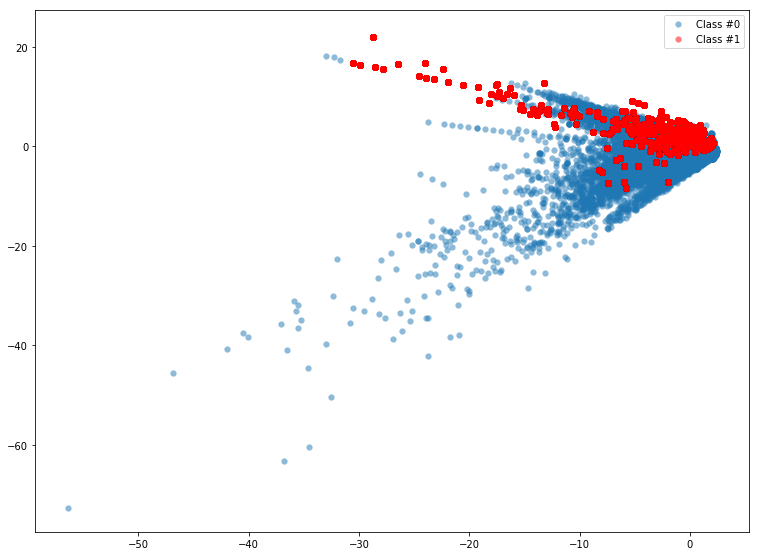

In [31]:
osr = RandomOverSampler()
X_osr_train, y_osr_train = osr.fit_sample(X_train, y_train)

plt.figure(figsize= [12.8, 9.6])
plot_data(X_osr_train, y_osr_train)

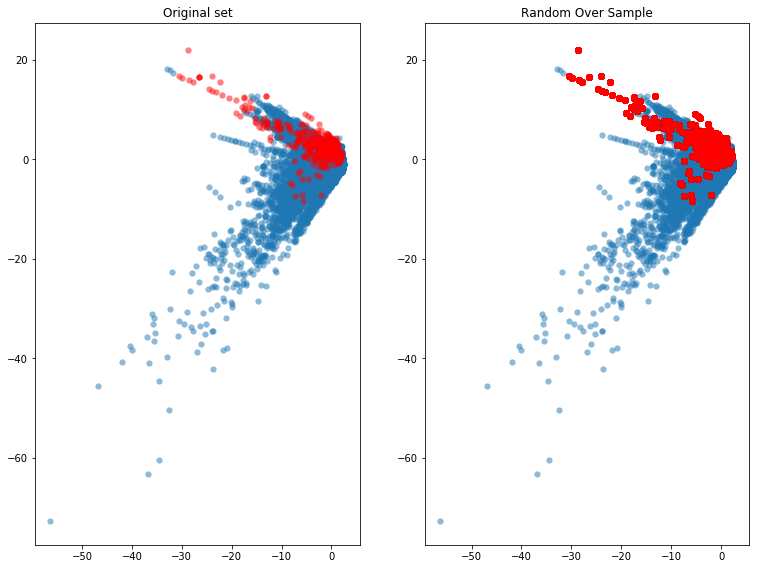

In [32]:
plt.figure(figsize= [12.8, 9.6])
compare_plot(X_train, y_train, X_osr_train, y_osr_train, method='Random Over Sample')

2. using SMOTE for over sample 

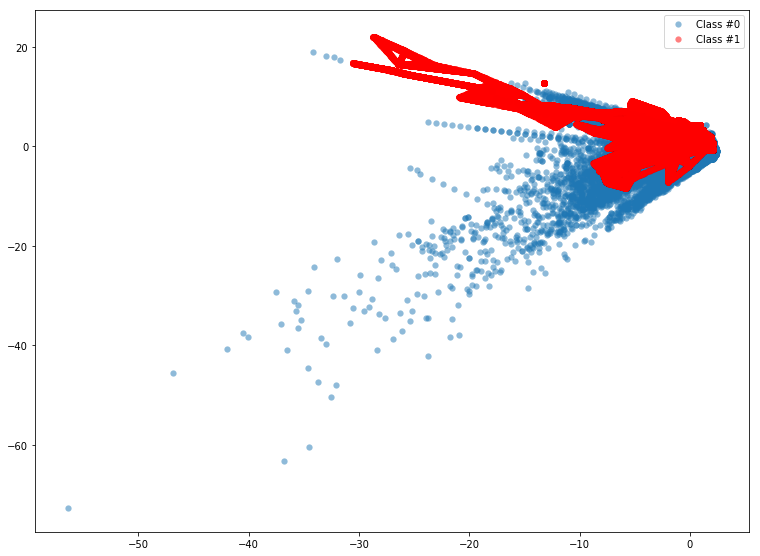

In [33]:
smt = SMOTE()
X_smote_over, y_smote_over = smt.fit_sample(X, y)

plt.figure(figsize= [12.8, 9.6])
plot_data(X_smote_over, y_smote_over)

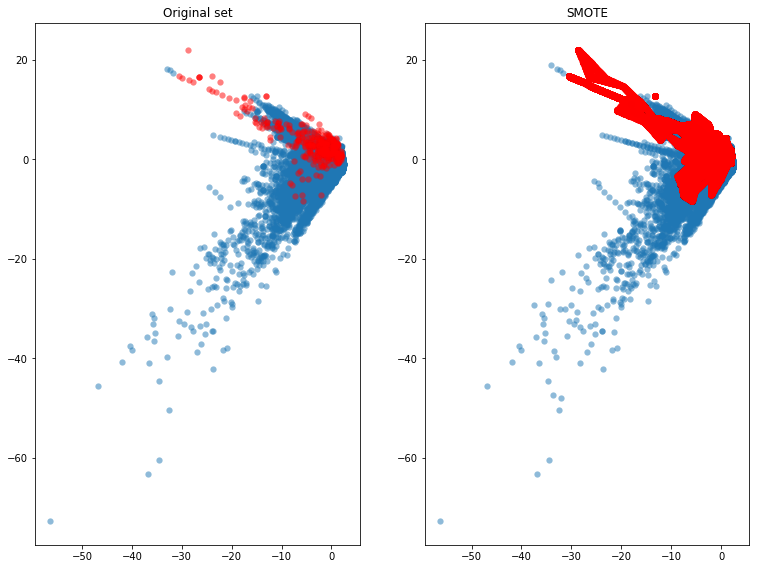

In [20]:
plt.figure(figsize= [12.8, 9.6])
compare_plot(X_train, y_train, X_smote_over, y_smote_over, method='SMOTE')

3. Under sample.

In [21]:
# This function create the undersempling
def resampling(data, perc_resampling = 0.5, m = [1, 0], status = "Class"):
    n = len(data[data[status] == m[0]])
    i = np.array(data[data[status] == m[0]].index)
    ni = data[data[status] == m[1]].index
    rni = np.array(np.random.choice(ni, n, replace = False))
    usi = np.concatenate([i, rni])
    usd = data.iloc[usi,:]
    
    X = usd.drop(status, axis = 1)
    y = usd[status]
    
    return X, y

X_under, y_under = resampling(fraudetection)

print("total is: " + str(len(X_under)))

table(np.array(y_under))

total is: 984
There are 492 values equal to 1, and 492 equal to 0. There not are imbalanced.


# Oversampling model with ROS.

## K-Nearest Neighbors

Choice the best paramerts.

In [37]:
knn = KNeighborsClassifier(n_jobs=-1)

In [38]:
params_grid = {'weights': ['uniform', 'distance'],
              'n_neighbors': list(range(1,9))}
cv_model = GridSearchCV(estimator=knn, param_grid=params_grid, cv = 5, scoring='f1')

In [39]:
cv_model.fit(X_osr_train, y_osr_train)
cv_model.best_params_

{'n_neighbors': 1, 'weights': 'uniform'}

Model with best paramerts

In [40]:
knn_osr_best = KNeighborsClassifier(weights='uniform', n_neighbors=1, n_jobs=-1)

In [41]:
knn_osr_best.fit(X_osr_train, y_osr_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=1)

In [42]:
predict_knn = knn_osr_best.predict(X_test)

In [43]:
print(metrics.confusion_matrix(y_test, predict_knn))
print(metrics.classification_report(y_test, predict_knn))

[[85287    20]
 [   23   113]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.85      0.83      0.84       136

    accuracy                           1.00     85443
   macro avg       0.92      0.92      0.92     85443
weighted avg       1.00      1.00      1.00     85443



## Logistic Regression

Choice the best paramerts.

In [32]:
logreg = LogisticRegression(max_iter=400, n_jobs=-1)

In [44]:
params_grid1 = {'penalty': ['l2','none'],
               'class_weight': [{1:15, 0:1}, {1:10, 0:2}, {1:5, 0:3}, {1:2, 0:1}]}
cv_model1 = GridSearchCV(estimator=logreg, param_grid=params_grid1, cv = 5, scoring='f1')

In [45]:
cv_model1.fit(X_osr_train, y_osr_train)
cv_model1.best_params_

{'class_weight': {1: 5, 0: 3}, 'penalty': 'l2'}

Model with best paramerts

In [46]:
logreg_ors_best = LogisticRegression(class_weight={1: 5, 0: 3}, penalty='l2', max_iter=400, n_jobs=-1)

In [47]:
logreg_ors_best.fit(X_osr_train, y_osr_train)

LogisticRegression(class_weight={0: 3, 1: 5}, max_iter=400, n_jobs=-1)

In [49]:
predict_lr = logreg_ors_best.predict(X_test)

In [51]:
print(metrics.confusion_matrix(y_test, predict_lr))
print(metrics.classification_report(y_test, predict_lr))

[[81527  3780]
 [    9   127]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     85307
           1       0.03      0.93      0.06       136

    accuracy                           0.96     85443
   macro avg       0.52      0.94      0.52     85443
weighted avg       1.00      0.96      0.98     85443



## Random Forest

Choice the best paramerts.

In [52]:
rf = RandomForestClassifier(n_jobs=-1)

In [55]:
params_grid2 = {
    'n_estimators': [1, 20, 30, 50],
    'criterion': ["gini", "entropy"],
    'max_depth': [2, 4, 6, 8],
    'max_features': ['auto', 'log2']
}
cv_model2 = GridSearchCV(estimator=rf, param_grid=params_grid2, cv= 5, scoring='f1')

In [56]:
cv_model2.fit(X_osr_train, y_osr_train)
cv_model2.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 20}

Model with best paramerts

In [58]:
rf_ors_best = RandomForestClassifier(n_estimators=20, criterion='entropy', max_features='auto', max_depth= 8, n_jobs=-1)

In [59]:
rf_ors_best.fit(X_osr_train, y_osr_train)

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=20,
                       n_jobs=-1)

In [60]:
predict_rf = rf_ors_best.predict(X_test)

In [61]:
print(metrics.confusion_matrix(y_test, predict_rf))
print(metrics.classification_report(y_test, predict_rf))

[[85254    53]
 [   18   118]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.69      0.87      0.77       136

    accuracy                           1.00     85443
   macro avg       0.84      0.93      0.88     85443
weighted avg       1.00      1.00      1.00     85443



## Voting Classifier

In [78]:
ensemble_model = VotingClassifier(estimators=[('knn', knn_osr_best), 
                                              ('lr', logreg_ors_best), 
                                              ('rf', rf_ors_best)], 
                                  voting='soft', n_jobs=-1)

In [85]:
params_grid_vc = {
    'weights': [[1, 2, 1], [1, 1, 2], [2, 1, 1], [1, 1, 1], [2, 1, 2], [1, 2, 2], [2, 2, 1]]
}
cv_model3 = GridSearchCV(estimator=ensemble_model, param_grid=params_grid_vc, cv=5, scoring='f1')

In [87]:
cv_model3.fit(X_osr_train, y_osr_train)
cv_model3.best_params_

{'weights': [2, 1, 1]}

In [88]:
ensemble_model_best = VotingClassifier(estimators=[('knn', knn_osr_best), 
                                              ('lr', logreg_ors_best), 
                                              ('rf', rf_ors_best)], 
                                      voting='soft', n_jobs=-1, 
                                      weights= [2, 1, 1])

In [89]:
ensemble_model_best.fit(X_osr_train, y_osr_train)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(n_jobs=-1, n_neighbors=1)),
                             ('lr',
                              LogisticRegression(class_weight={0: 3, 1: 5},
                                                 max_iter=400, n_jobs=-1)),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_depth=8,
                                                     n_estimators=20,
                                                     n_jobs=-1))],
                 n_jobs=-1, voting='soft', weights=[2, 1, 1])

Model metrics of accuracy

In [90]:
predict_1 = ensemble_model_best.predict(X_test)

In [91]:
print(metrics.confusion_matrix(y_test, predict_1))
print(metrics.classification_report(y_test, predict_1))

[[85287    20]
 [   23   113]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.85      0.83      0.84       136

    accuracy                           1.00     85443
   macro avg       0.92      0.92      0.92     85443
weighted avg       1.00      1.00      1.00     85443



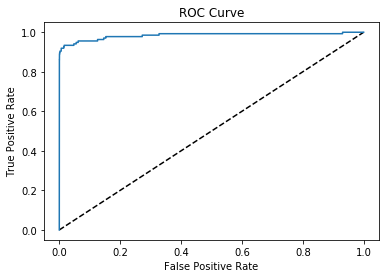

In [93]:
y_pred_prob1 = ensemble_model_best.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob1)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

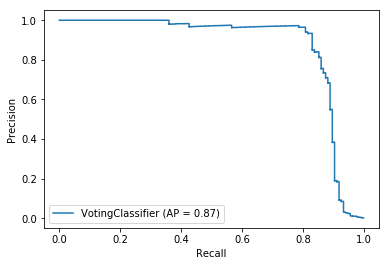

In [97]:
metrics.plot_precision_recall_curve(ensemble_model_best, X_test, y_test)

In [96]:
rs = metrics.recall_score(y_test, predict_1)
acc = metrics.accuracy_score(y_test, predict_1)

print("Recall score: ", rs, "Accuracy: ", acc)

Recall score:  0.8308823529411765 Accuracy:  0.9994967405170698


# Oversampling model with SMOTE.

## K-Nearest Neighbors

In [98]:
knn1 = KNeighborsClassifier(n_jobs=-1)

In [99]:
params_grid = {'weights': ['uniform', 'distance'],
              'n_neighbors': list(range(1,9))}
cv_model_smote = GridSearchCV(estimator=knn1, param_grid=params_grid, cv = 5, scoring='f1')

In [100]:
cv_model_smote.fit(X_smote_over, y_smote_over)
cv_model_smote.best_params_

{'n_neighbors': 2, 'weights': 'uniform'}

In [3]:
knn1_smote_best = KNeighborsClassifier(n_neighbors=2, weights='uniform', n_jobs=-1)

In [102]:
knn1_smote_best.fit(X_smote_over, y_smote_over)

KNeighborsClassifier(n_jobs=-1, n_neighbors=2)

In [104]:
predict_knn1 = knn1_smote_best.predict(X_test)

In [105]:
print(metrics.confusion_matrix(y_test, predict_knn1))
print(metrics.classification_report(y_test, predict_knn1))

[[85307     0]
 [    0   136]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       1.00      1.00      1.00       136

    accuracy                           1.00     85443
   macro avg       1.00      1.00      1.00     85443
weighted avg       1.00      1.00      1.00     85443



## Logistic Regression

In [106]:
logreg1 = LogisticRegression(n_jobs=-1, max_iter=400)

In [108]:
params_grid1 = {'penalty': ['l2','none'],
               'class_weight': [{1:15, 0:1}, {1:10, 0:2}, {1:5, 0:3}, {1:2, 0:1}]}
cv_model_smote1 = GridSearchCV(estimator=logreg1, param_grid=params_grid1, cv = 5, scoring='f1')

In [109]:
cv_model_smote1.fit(X_smote_over, y_smote_over)
cv_model_smote1.best_params_

{'class_weight': {1: 5, 0: 3}, 'penalty': 'none'}

In [4]:
logreg1_smote_best = LogisticRegression(max_iter=400, n_jobs=-1, penalty='none', class_weight= {1: 5, 0: 3})

In [ ]:
logreg1_smote_best.fit(X_smote_over, y_smote_over)

In [111]:
predict_lr1 = logreg1_smote_best.predict(X_test)

In [112]:
print(metrics.confusion_matrix(y_test, predict_lr1))
print(metrics.classification_report(y_test, predict_lr1))

[[81775  3532]
 [    7   129]]
              precision    recall  f1-score   support

           0       1.00      0.96      0.98     85307
           1       0.04      0.95      0.07       136

    accuracy                           0.96     85443
   macro avg       0.52      0.95      0.52     85443
weighted avg       1.00      0.96      0.98     85443



## Random Forest

In [22]:
rf1 = RandomForestClassifier(n_jobs=-1)

In [23]:
params_grid2 = {
    'n_estimators': [1, 20, 30, 50],
    'criterion': ["gini", "entropy"],
    'max_depth': [2, 4, 6, 8],
    'max_features': ['auto', 'log2']
}
cv_model_smote2 = GridSearchCV(estimator=rf1, param_grid=params_grid2, cv= 5, scoring='f1')

In [24]:
cv_model_smote2.fit(X_smote_over, y_smote_over)
cv_model_smote2.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 50}

In [5]:
rf1_smote_best = RandomForestClassifier(criterion='gini', max_depth=8, max_features='auto', n_estimators=50, n_jobs=-1)

In [26]:
rf1_smote_best.fit(X_smote_over, y_smote_over)

RandomForestClassifier(max_depth=8, n_estimators=50, n_jobs=-1)

In [27]:
predict_rf1 = rf1_smote_best.predict(X_test)

In [28]:
print(metrics.confusion_matrix(y_test, predict_rf1))
print(metrics.classification_report(y_test, predict_rf1))

[[85088   219]
 [    4   132]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.38      0.97      0.54       136

    accuracy                           1.00     85443
   macro avg       0.69      0.98      0.77     85443
weighted avg       1.00      1.00      1.00     85443



## Voting Classifier

In [31]:
ensemble_model1 = VotingClassifier(estimators=[('knn', knn1_smote_best), 
                                              ('lr', logreg1_smote_best), 
                                              ('rf', rf1_smote_best)], 
                                  voting='soft', n_jobs=-1)

In [39]:
params_grid_vc1 = {
    'weights': [[1, 2, 1], [1, 1, 2], [2, 1, 1], [1, 1, 1], [2, 1, 2], [1, 2, 2], [2, 2, 1]]
}
cv_model_smote3 = GridSearchCV(estimator=ensemble_model1, 
                               param_grid=params_grid_vc1, 
                               cv=5, 
                               scoring='f1', 
                               n_jobs=-1)

In [40]:
cv_model_smote3.fit(X_smote_over, y_smote_over)
cv_model_smote3.best_params_

{'weights': [2, 1, 1]}

In [6]:
ensemble_model_best1 = VotingClassifier(estimators=[('knn', knn1_smote_best), 
                                              ('lr', logreg1_smote_best), 
                                              ('rf', rf1_smote_best)], 
                                      voting='soft', n_jobs=-1, 
                                      weights= [2, 1, 1])

In [34]:
ensemble_model_best1.fit(X_smote_over, y_smote_over)

VotingClassifier(estimators=[('knn',
                              KNeighborsClassifier(n_jobs=-1, n_neighbors=2)),
                             ('lr',
                              LogisticRegression(class_weight={0: 3, 1: 5},
                                                 max_iter=400, n_jobs=-1,
                                                 penalty='none')),
                             ('rf',
                              RandomForestClassifier(max_depth=8,
                                                     n_estimators=50,
                                                     n_jobs=-1))],
                 n_jobs=-1, voting='soft', weights=[2, 1, 1])

In [35]:
predict_2 = ensemble_model_best1.predict(X_test)

In [36]:
print(metrics.confusion_matrix(y_test, predict_2))
print(metrics.classification_report(y_test, predict_2))

[[85284    23]
 [    0   136]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.86      1.00      0.92       136

    accuracy                           1.00     85443
   macro avg       0.93      1.00      0.96     85443
weighted avg       1.00      1.00      1.00     85443



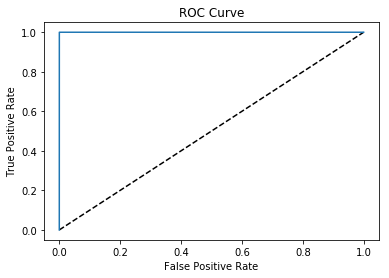

In [45]:
y_pred_prob2 = ensemble_model_best1.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob2)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

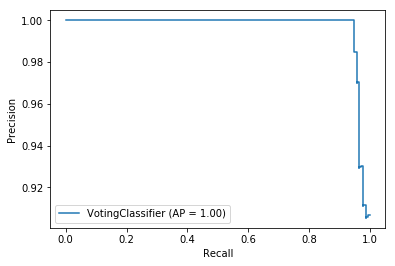

In [46]:
metrics.plot_precision_recall_curve(ensemble_model_best1, X_test, y_test)

In [47]:
rs = metrics.recall_score(y_test, predict_2)
acc = metrics.accuracy_score(y_test, predict_2)

print("Recall score: ", rs, "Accuracy: ", acc)

Recall score:  1.0 Accuracy:  0.9997308146951769


# Saving the best model

In [48]:
joblib.dump(ensemble_model_best1, "./train_best_model.joblib", compress=True)

['./train_best_model.joblib.z']

The best model is K-neighbors, because the prediction is very best, where of the predictions of fraud is very accuracy.
therefore:
* The accuracy of the transaction is fraudulent is 98%.